In [1]:
# since my model actually calls tools what do I need to 
# create research assistant with human in the loop

# I need great prompts
# prompts for planning the research topic
# prompt for writing the well planned structure
# System prompt
# I would like to add human in the loop to steer it in the write direction incase.

In [2]:
from typing import TypedDict, List
# For graph state
class AgentState(TypedDict):
    task: str
    outline: str
    research: str
    critique: str
    content: List[str]
    revisions: int
    max_revisions: int

In [3]:
# for tools
from langchain_tavily import TavilySearch
from dotenv import load_dotenv, find_dotenv
import openai

_ = load_dotenv(find_dotenv())

In [4]:
search_tool = TavilySearch(max_results=2,
                          topic="general",
                           time_range="year",
                      )

In [5]:
search_tool.invoke({"query": "What happened at the last wimbledon"})

{'query': 'What happened at the last wimbledon',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.usatoday.com/story/sports/tennis/wimb/2025/07/13/wimbledon-mens-final-results-highlights-alcaraz-sinner/84691902007/',
   'title': "Wimbledon men's final: Jannik Sinner overpowers Carlos ...",
   'content': "World No. 1 Jannik Sinner denied No. 2 Carlos Alcaraz a three-peat at Wimbledon, winning the latest edition of tennis' best rivalry in four sets – and avenging",
   'score': 0.3309905,
   'raw_content': None},
  {'url': 'https://www.nbcnews.com/sports/tennis/wimbledon-final-jannik-sinner-carlos-alcaraz-champagne-cork-rcna218555',
   'title': 'In Wimbledon final, Jannik Sinner had to deal with Carlos ...',
   'content': "# In Wimbledon final, Jannik Sinner had to deal with Carlos Alcaraz — and a flying Champagne cork Sinner would go on to defeat Alcaraz in four sets to claim his first Wimbledon trophy. Italy's Jannik Sinner picks up a cork 

In [6]:
# prompts
OUTLINE_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""


WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed: 

------

{content}"""


REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""


RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""


RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""

In [7]:
from pydantic import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [8]:
from tavily import TavilyClient
import os
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [9]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, AnyMessage, SystemMessage, ToolMessage, HumanMessage

In [10]:
model_name = "gpt-4o"
model = ChatOpenAI(model=model_name, temperature=0.0)

In [11]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=OUTLINE_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"outline": response.content}

In [12]:
def research_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state.get("content", [])
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [13]:
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['outline']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)
    return {
        "research": response.content, 
        "revisions": state.get("revisions", 1) + 1
    }


In [14]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['research'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [15]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [16]:
def should_continue(state):
    if state["revisions"] > state["max_revisions"]:
        return END
    return "reflect"

In [17]:
from langgraph.graph import StateGraph,END

In [18]:
builder = StateGraph(AgentState)

In [19]:
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research", research_node)
builder.add_node("critique_draft", research_critique_node)

In [20]:
builder.set_entry_point("planner")

In [21]:
builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {END: END, "reflect": "reflect"}
)


In [22]:
builder.add_edge("planner", "research")
builder.add_edge("research", "generate")

builder.add_edge("reflect", "critique_draft")
builder.add_edge("critique_draft", "generate")

In [23]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = 'checkpoints.db'
conn = sqlite3.connect(db_path, check_same_thread=False)

memory = SqliteSaver(conn)

In [24]:
graph = builder.compile(checkpointer=memory)

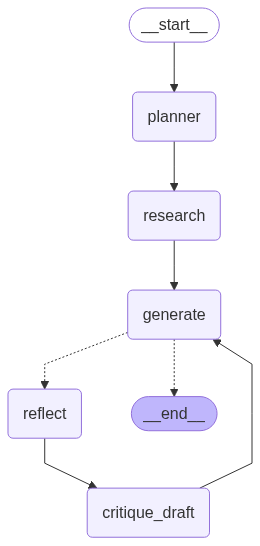

In [25]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [26]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'task': "what is the difference between langchain and langsmith",
    "max_revisions": 2,
    "revisions": 1,
    "content": []
}, thread):
    print(s)

{'planner': {'outline': 'Title: Understanding the Differences Between LangChain and LangSmith\n\nI. Introduction\n   A. Brief introduction to the importance of language processing tools in modern technology.\n   B. Introduction to LangChain and LangSmith as prominent tools in the field.\n   C. Purpose of the essay: To explore and differentiate between LangChain and LangSmith.\n\nII. Overview of LangChain\n   A. Definition and primary function of LangChain.\n   B. Key features and capabilities.\n      1. Language model integration.\n      2. Workflow automation.\n      3. Customization and scalability.\n   C. Typical use cases and applications.\n   D. Advantages and limitations.\n\nIII. Overview of LangSmith\n   A. Definition and primary function of LangSmith.\n   B. Key features and capabilities.\n      1. Language processing and analysis.\n      2. Data management and transformation.\n      3. User interface and ease of use.\n   C. Typical use cases and applications.\n   D. Advantages

In [ ]:
# add interupt for human in the loop when compiling the graph

In [29]:
graph.get_state(thread).next

()

In [ ]:

builder = StateGraph(AgentState)
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research", research_node)
builder.add_node("critique_draft", research_critique_node)
builder.set_entry_point("planner")
builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {END: END, "reflect": "reflect"}
)


builder.add_edge("planner", "research")
builder.add_edge("research", "generate")
builder.add_edge("reflect", "critique_draft")
builder.add_edge("critique_draft", "generate")

In [ ]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = ':memory:'
conn = sqlite3.connect(db_path, check_same_thread=False)

memory = SqliteSaver(conn)

In [ ]:
graph = builder.compile(checkpointer=memory,
                        interrupt_before=['planner', 'generate', 'reflect', 'research', 'critique_draft'])

In [ ]:
thread = {"configurable": {"thread_id": "2"}}
for s in graph.stream({
    'task': "what is the difference between langchain and langsmith",
    "max_revisions": 2,
    "revisions": 1,
    "content": []
}, thread):
    print(s)